In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

base_path = "/content/drive/MyDrive"
folders = ["imgs_part_1", "imgs_part_2", "imgs_part_3"]

for folder in folders:
    path = os.path.join(base_path, folder)
    print(f"{folder} → Exists:", os.path.exists(path))


imgs_part_1 → Exists: True
imgs_part_2 → Exists: True
imgs_part_3 → Exists: True


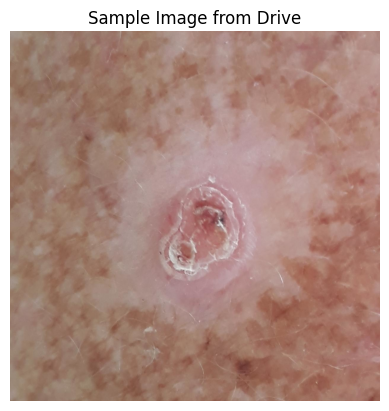

In [4]:
import matplotlib.pyplot as plt
import cv2

sample_path = "/content/drive/MyDrive/imgs_part_1"
sample_image = os.path.join(sample_path, os.listdir(sample_path)[0])

img = cv2.imread(sample_image)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Sample Image from Drive")
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Metadata loaded successfully!
(2298, 26)
Total images found: 2,298
Images matched in metadata: 2298
Cleaned metadata entries: 2298


/tmp/ipython-input-2806607042.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["diagnostic"], palette="Set2")


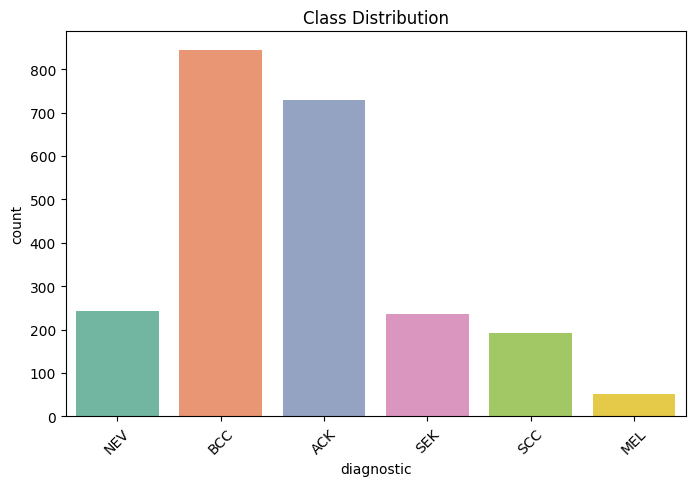

✅ Encoded Classes:
0 → ACK
1 → BCC
2 → MEL
3 → NEV
4 → SCC
5 → SEK
Train: 1838, Val: 230, Test: 230


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


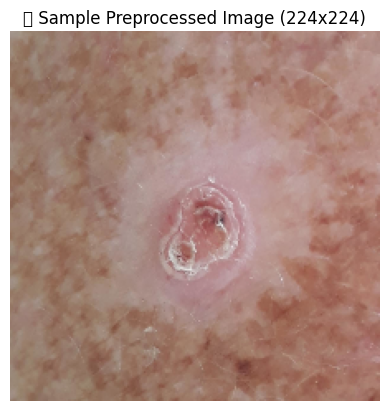

⏳ Building Train Dataset...


100%|██████████| 1838/1838 [12:37<00:00,  2.43it/s]


⏳ Building Validation Dataset...


100%|██████████| 230/230 [01:07<00:00,  3.41it/s]


⏳ Building Test Dataset...


100%|██████████| 230/230 [01:04<00:00,  3.55it/s]


✅ Dataset Shapes:
X_train: (1838, 224, 224, 3), y_train: (1838,)
X_val: (230, 224, 224, 3), y_val: (230,)
X_test: (230, 224, 224, 3), y_test: (230,)
✅ Preprocessed arrays saved to: /content/drive/MyDrive/AML2_Project_Preprocessed


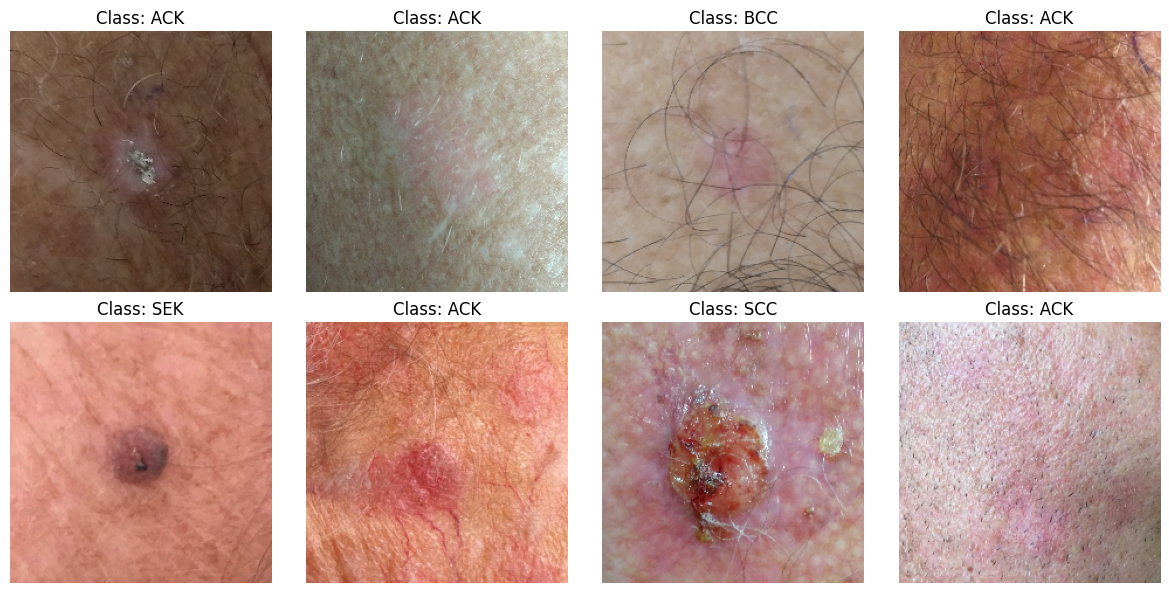

In [5]:
# ===============================================================
# 📦 PHASE 2: Preprocessing & Data Pipeline for Skin Lesion Images
# ===============================================================

import os
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================================================
# STEP 1: Mount Google Drive
# ===============================================================

from google.colab import drive
drive.mount('/content/drive')

# ===============================================================
# STEP 2: Define Paths
# ===============================================================

base_path = "/content/drive/MyDrive"  # your Drive path
image_folders = ["imgs_part_1", "imgs_part_2", "imgs_part_3"]
metadata_path = os.path.join(base_path, "metadata.csv")

# Load metadata
df = pd.read_csv(metadata_path)
print("✅ Metadata loaded successfully!")
print(df.shape)
df.head()

# ===============================================================
# STEP 3: Combine all image paths
# ===============================================================

image_paths = []
for folder in image_folders:
    folder_path = os.path.join(base_path, folder)
    for img_name in os.listdir(folder_path):
        image_paths.append(os.path.join(folder_path, img_name))

print(f"Total images found: {len(image_paths):,}")

# ===============================================================
# STEP 4: Verify image–metadata match
# ===============================================================

df["has_image"] = df["img_id"].apply(lambda x: any(x in path for path in image_paths))
print("Images matched in metadata:", df["has_image"].sum())

df = df[df["has_image"]]  # keep only rows with matching images
df.reset_index(drop=True, inplace=True)
print(f"Cleaned metadata entries: {len(df)}")

# ===============================================================
# STEP 5: Visualize class distribution
# ===============================================================

plt.figure(figsize=(8,5))
sns.countplot(x=df["diagnostic"], palette="Set2")
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# ===============================================================
# STEP 6: Encode target labels
# ===============================================================

label_encoder = LabelEncoder()
df["label_encoded"] = label_encoder.fit_transform(df["diagnostic"])
class_names = label_encoder.classes_

print("✅ Encoded Classes:")
for i, c in enumerate(class_names):
    print(f"{i} → {c}")

# ===============================================================
# STEP 7: Create Train/Validation/Test Splits
# ===============================================================

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label_encoded"], random_state=42)
val_df, test_df = train_test_split(test_df, test_size=0.5, stratify=test_df["label_encoded"], random_state=42)

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

# ===============================================================
# STEP 8: Preprocess Images (Resize + Normalize)
# ===============================================================

IMG_SIZE = 224

def load_and_preprocess(img_path):
    """Reads image, resizes to 224x224, and normalizes to [0,1]."""
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img / 255.0

# Test one image
sample_path = os.path.join(base_path, "imgs_part_1", os.listdir(os.path.join(base_path, "imgs_part_1"))[0])
sample_img = load_and_preprocess(sample_path)
plt.imshow(sample_img)
plt.title("✅ Sample Preprocessed Image (224x224)")
plt.axis('off')
plt.show()

# ===============================================================
# STEP 9: Build NumPy Arrays for Each Split
# ===============================================================

def build_dataset(df_subset):
    X, y = [], []
    for i, row in tqdm(df_subset.iterrows(), total=len(df_subset)):
        img_id = row["img_id"]
        img_path = next((p for p in image_paths if img_id in p), None)
        if img_path:
            X.append(load_and_preprocess(img_path))
            y.append(row["label_encoded"])
    return np.array(X), np.array(y)

print("⏳ Building Train Dataset...")
X_train, y_train = build_dataset(train_df)

print("⏳ Building Validation Dataset...")
X_val, y_val = build_dataset(val_df)

print("⏳ Building Test Dataset...")
X_test, y_test = build_dataset(test_df)

print(f"✅ Dataset Shapes:")
print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")

# ===============================================================
# STEP 10: Save Preprocessed Data
# ===============================================================

save_path = os.path.join(base_path, "AML2_Project_Preprocessed")
os.makedirs(save_path, exist_ok=True)

np.save(os.path.join(save_path, "X_train.npy"), X_train)
np.save(os.path.join(save_path, "y_train.npy"), y_train)
np.save(os.path.join(save_path, "X_val.npy"), X_val)
np.save(os.path.join(save_path, "y_val.npy"), y_val)
np.save(os.path.join(save_path, "X_test.npy"), X_test)
np.save(os.path.join(save_path, "y_test.npy"), y_test)

print(f"✅ Preprocessed arrays saved to: {save_path}")

# ===============================================================
# STEP 11: Preview Few Samples
# ===============================================================

fig, axes = plt.subplots(2, 4, figsize=(12,6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(f"Class: {class_names[y_train[i]]}")
    ax.axis('off')
plt.tight_layout()
plt.show()


In [6]:
base_path = "/content/drive/MyDrive/AML2_Project_Preprocessed/"


In [7]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/AML2_Project_Preprocessed"

X_train = np.load(os.path.join(base_path, "X_train.npy"))
y_train = np.load(os.path.join(base_path, "y_train.npy"))
X_val = np.load(os.path.join(base_path, "X_val.npy"))
y_val = np.load(os.path.join(base_path, "y_val.npy"))
X_test = np.load(os.path.join(base_path, "X_test.npy"))
y_test = np.load(os.path.join(base_path, "y_test.npy"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data loaded successfully!
Train: (1838, 224, 224, 3), Validation: (230, 224, 224, 3), Test: (230, 224, 224, 3)
Number of classes: 6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,170,630 (42.61 MB)

 Trainable params: 11,170,182 (42.61 MB)

 Non-trainable params: 448 (1.75 KB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3234 - loss: 3.2257

58/58 ━━━━━━━━━━━━━━━━━━━━ 255s 4s/step - accuracy: 0.3239 - loss: 3.2082 - val_accuracy: 0.1043 - val_loss: 3.4412
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4164 - loss: 1.5529

58/58 ━━━━━━━━━━━━━━━━━━━━ 249s 4s/step - accuracy: 0.4162 - loss: 1.5535 - val_accuracy: 0.3174 - val_loss: 3.7000
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.4170 - loss: 1.5770 - val_accuracy: 0.3174 - val_loss: 6.2572
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 244s 4s/step - accuracy: 0.4262 - loss: 1.4978 - val_accuracy: 0.3174 - val_loss: 7.3274
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 234s 4s/step - accuracy: 0.4509 - loss: 1.4654 - val_accuracy: 0.3174 - val_loss: 6.4532
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4041 - loss: 1.5727

58/58 ━━━━━━━━━━━━━━━━━━━━ 228s 4s/step - accuracy: 0.4045 - loss: 1.5714 - val_accuracy: 0.3304 - val_loss: 5.2245


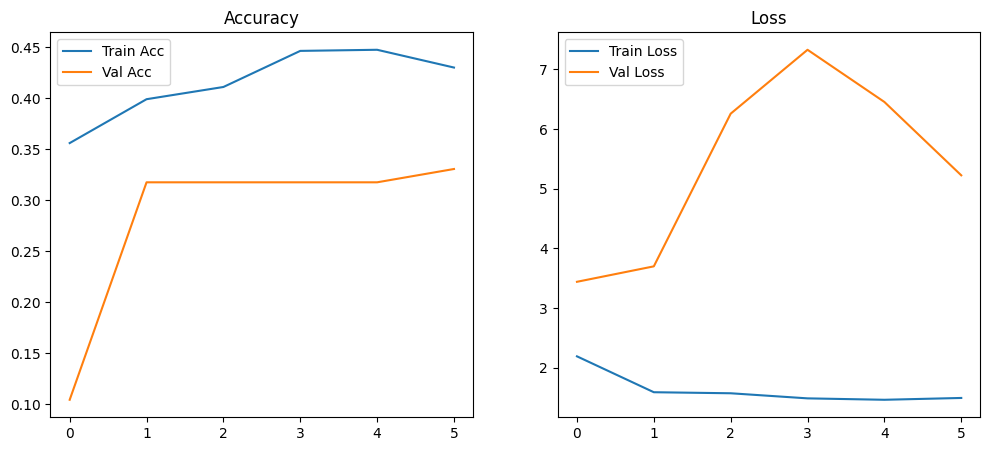

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.0967 - loss: 3.4967


✅ Test Accuracy: 10.00%
✅ Model & training log saved at: /content/drive/MyDrive/AML2_Project_Models/cnn_model.h5
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 625ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        73
           1       0.00      0.00      0.00        85
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00        24
           4       0.00      0.00      0.00        20
           5       0.10      1.00      0.18        23

    accuracy                           0.10       230
   macro avg       0.02      0.17      0.03       230
weighted avg       0.01      0.10      0.02       230



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


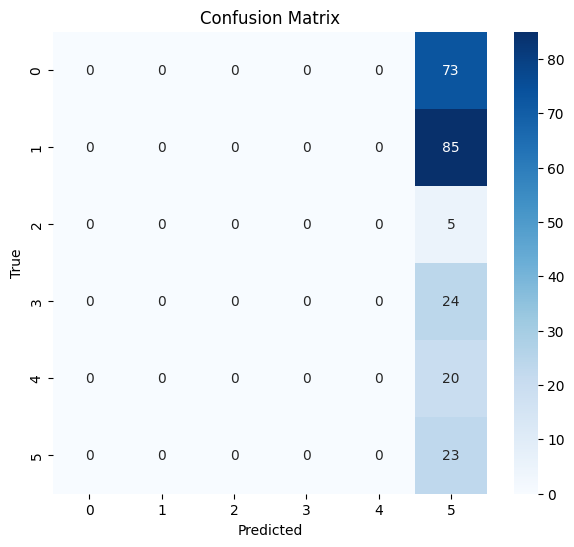

In [8]:
# ===============================================================
# 🧠 PHASE 3: Model Development & Training (cnn_model.py)
# ===============================================================

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# ===============================================================
# STEP 1: Mount Google Drive & Define Paths
# ===============================================================
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/AML2_Project_Preprocessed"

X_train = np.load(os.path.join(base_path, "X_train.npy"))
y_train = np.load(os.path.join(base_path, "y_train.npy"))
X_val = np.load(os.path.join(base_path, "X_val.npy"))
y_val = np.load(os.path.join(base_path, "y_val.npy"))
X_test = np.load(os.path.join(base_path, "X_test.npy"))
y_test = np.load(os.path.join(base_path, "y_test.npy"))

print(f"✅ Data loaded successfully!")
print(f"Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}")

# ===============================================================
# STEP 2: Prepare Labels (One-hot encoding)
# ===============================================================
from tensorflow.keras.utils import to_categorical

num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)
y_test = to_categorical(y_test, num_classes)

print(f"Number of classes: {num_classes}")

# ===============================================================
# STEP 3: Data Augmentation
# ===============================================================
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_gen = val_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)

# ===============================================================
# STEP 4: Build CNN Model (Baseline)
# ===============================================================

def build_cnn(input_shape=(224, 224, 3), num_classes=6):
    model = Sequential([
        Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.2),

        Conv2D(64, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.3),

        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2,2),
        Dropout(0.4),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = build_cnn()
model.summary()

# ===============================================================
# STEP 5: Compile Model
# ===============================================================

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ===============================================================
# STEP 6: Callbacks for Early Stop & Model Checkpoint
# ===============================================================

checkpoint_path = "/content/drive/MyDrive/AML2_Project_Models/cnn_model.h5"
os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_accuracy')
]

# ===============================================================
# STEP 7: Train Model
# ===============================================================

history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=callbacks
)

# ===============================================================
# STEP 8: Plot Training Curves
# ===============================================================

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend(); plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend(); plt.title("Loss")
plt.show()

# ===============================================================
# STEP 9: Evaluate Model
# ===============================================================

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

# ===============================================================
# STEP 10: Save Model & Training History
# ===============================================================

model.save(checkpoint_path)

# Save training logs
import pandas as pd
log_df = pd.DataFrame(history.history)
log_path = "/content/drive/MyDrive/AML2_Project_Models/training_log.csv"
log_df.to_csv(log_path, index=False)

print(f"✅ Model & training log saved at: {checkpoint_path}")

# ===============================================================
# STEP 11: Visualize Predictions
# ===============================================================
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Model & data loaded successfully!
Test data shape: (230, 224, 224, 3), Labels: (230,)
⚠️ History file not found. Skipping training curves.

🔍 Evaluating model on test data...
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 706ms/step

✅ Standard Accuracy: 10.00%
✅ Balanced Accuracy: 16.67%

📊 Classification Report:
              precision    recall  f1-score   support

         NEV       0.00      0.00      0.00        73
         ACK       0.00      0.00      0.00        85
         SEK       0.00      0.00      0.00         5
         BCC       0.00      0.00      0.00        24
         MEL       0.00      0.00      0.00        20
         SCC       0.10      1.00      0.18        23

    accuracy                           0.10       230
   macro avg       0.02      0.17      0.03       230
weighted avg       0.01      0.10      0.02       230



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


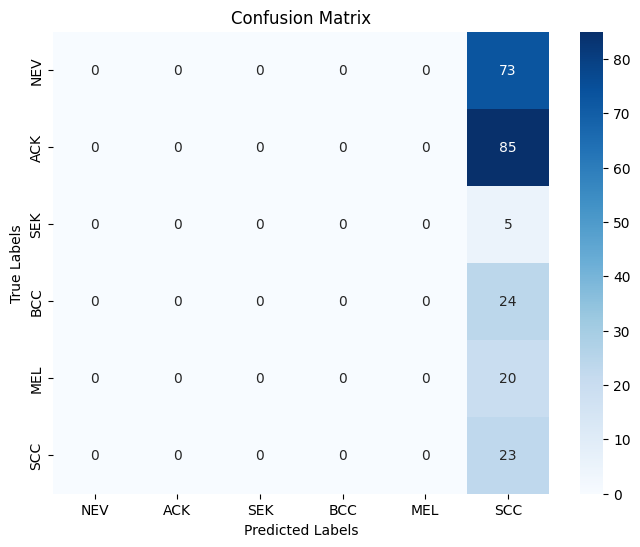

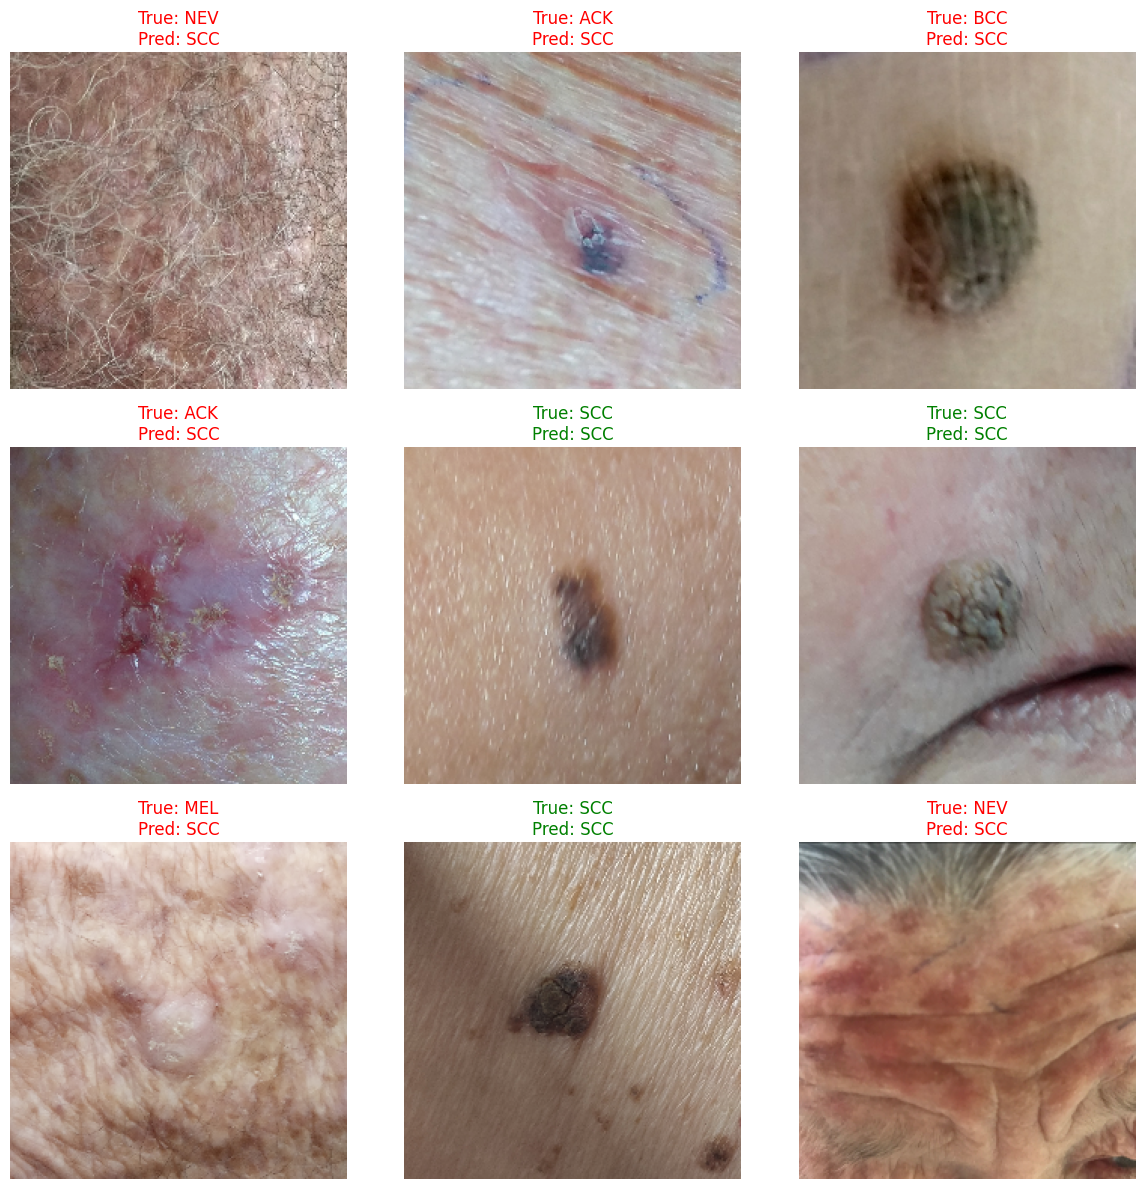

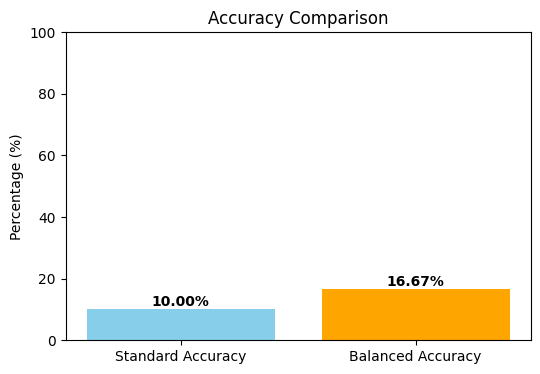


✅ Evaluation results saved to: /content/drive/MyDrive/AML2_Project_Results


In [9]:
# ==========================================
# 📘 PHASE 4: Model Evaluation & Visualization
# ==========================================

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    balanced_accuracy_score, accuracy_score
)
from tensorflow.keras.models import load_model

# --------------------------------------
# 1️⃣ Mount Drive and Set Paths
# --------------------------------------
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive"
model_path = os.path.join(base_path, "AML2_Project_Models/cnn_model.h5")
data_path  = os.path.join(base_path, "AML2_Project_Preprocessed")

# Load model and test data
model = load_model(model_path)
X_test = np.load(os.path.join(data_path, "X_test.npy"))
y_test = np.load(os.path.join(data_path, "y_test.npy"))

class_names = ['NEV', 'ACK', 'SEK', 'BCC', 'MEL', 'SCC']

print("✅ Model & data loaded successfully!")
print(f"Test data shape: {X_test.shape}, Labels: {y_test.shape}")

# --------------------------------------
# 2️⃣ Load Training History (optional)
# --------------------------------------
import pickle
history_path = os.path.join(base_path, "AML2_Project_Models/training_history.pkl")

if os.path.exists(history_path):
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    print("✅ Training history loaded!")
else:
    history = None
    print("⚠️ History file not found. Skipping training curves.")

# --------------------------------------
# 3️⃣ Plot Training Curves (if available)
# --------------------------------------
if history:
    plt.figure(figsize=(12,5))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Val Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs"); plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs"); plt.ylabel("Loss")
    plt.legend()

    plt.show()

# --------------------------------------
# 4️⃣ Evaluate on Test Set
# --------------------------------------
print("\n🔍 Evaluating model on test data...")
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# FIX: Handle label format automatically
if len(y_test.shape) == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

# Compute metrics
acc = accuracy_score(y_true, y_pred)
bal_acc = balanced_accuracy_score(y_true, y_pred)

print(f"\n✅ Standard Accuracy: {acc*100:.2f}%")
print(f"✅ Balanced Accuracy: {bal_acc*100:.2f}%\n")

print("📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# --------------------------------------
# 5️⃣ Confusion Matrix
# --------------------------------------
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# --------------------------------------
# 6️⃣ Visualise Random Predictions
# --------------------------------------
import random

def plot_predictions(X, y_true, y_pred, class_names, n=9):
    idxs = random.sample(range(len(X)), n)
    plt.figure(figsize=(12,12))
    for i, idx in enumerate(idxs):
        plt.subplot(3,3,i+1)
        plt.imshow(X[idx])
        true_label = class_names[y_true[idx]]
        pred_label = class_names[y_pred[idx]]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_predictions(X_test, y_true, y_pred, class_names)

# --------------------------------------
# 7️⃣ Accuracy Comparison Bar Plot
# --------------------------------------
plt.figure(figsize=(6,4))
plt.bar(["Standard Accuracy", "Balanced Accuracy"], [acc*100, bal_acc*100],
        color=["skyblue", "orange"])
plt.title("Accuracy Comparison")
plt.ylabel("Percentage (%)")
for i, v in enumerate([acc*100, bal_acc*100]):
    plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontweight='bold')
plt.ylim(0, 100)
plt.show()

# --------------------------------------
# 8️⃣ Save Evaluation Results
# --------------------------------------
results_dir = os.path.join(base_path, "AML2_Project_Results")
os.makedirs(results_dir, exist_ok=True)

np.save(os.path.join(results_dir, "y_true.npy"), y_true)
np.save(os.path.join(results_dir, "y_pred.npy"), y_pred)

print(f"\n✅ Evaluation results saved to: {results_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Model and data loaded successfully.
Test shape: (230, 224, 224, 3), Labels: (230,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

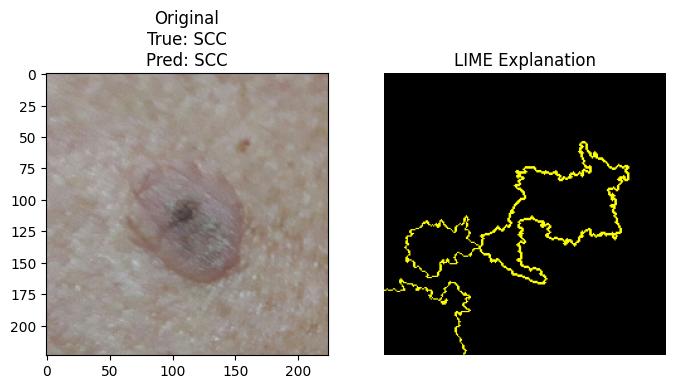

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

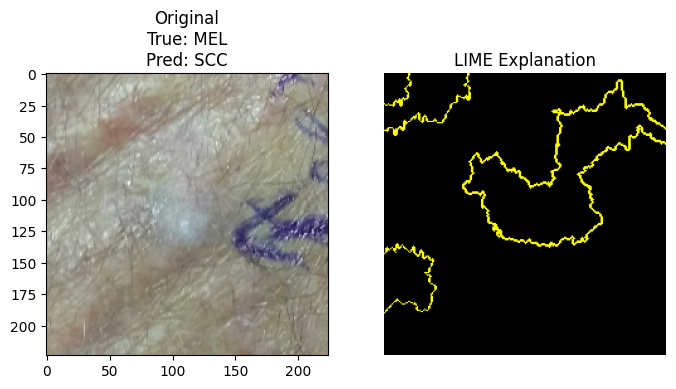

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

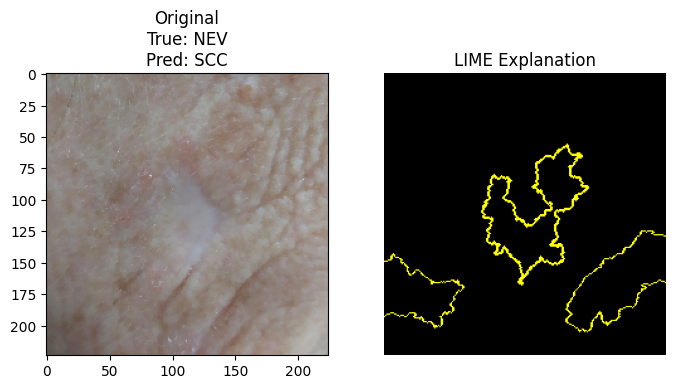

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

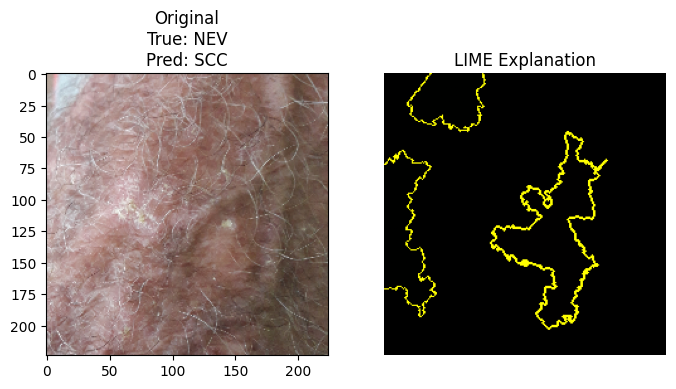

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

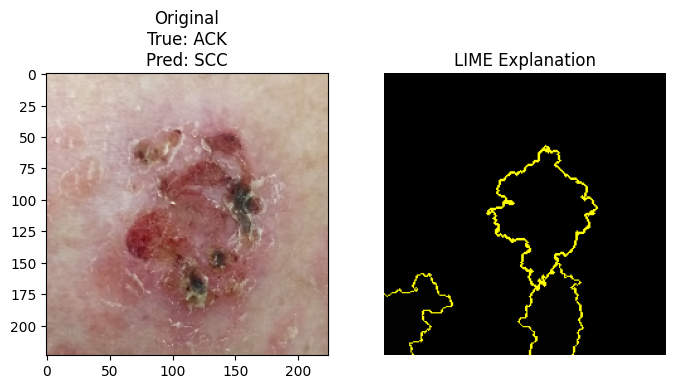

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(10, 224, 224, 3))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 224, 224, 3))']
  warnings.warn(msg)


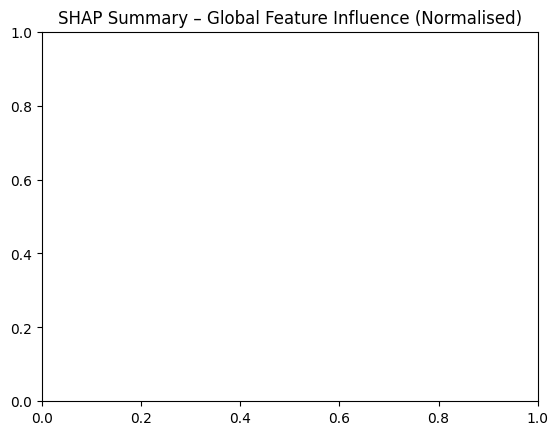

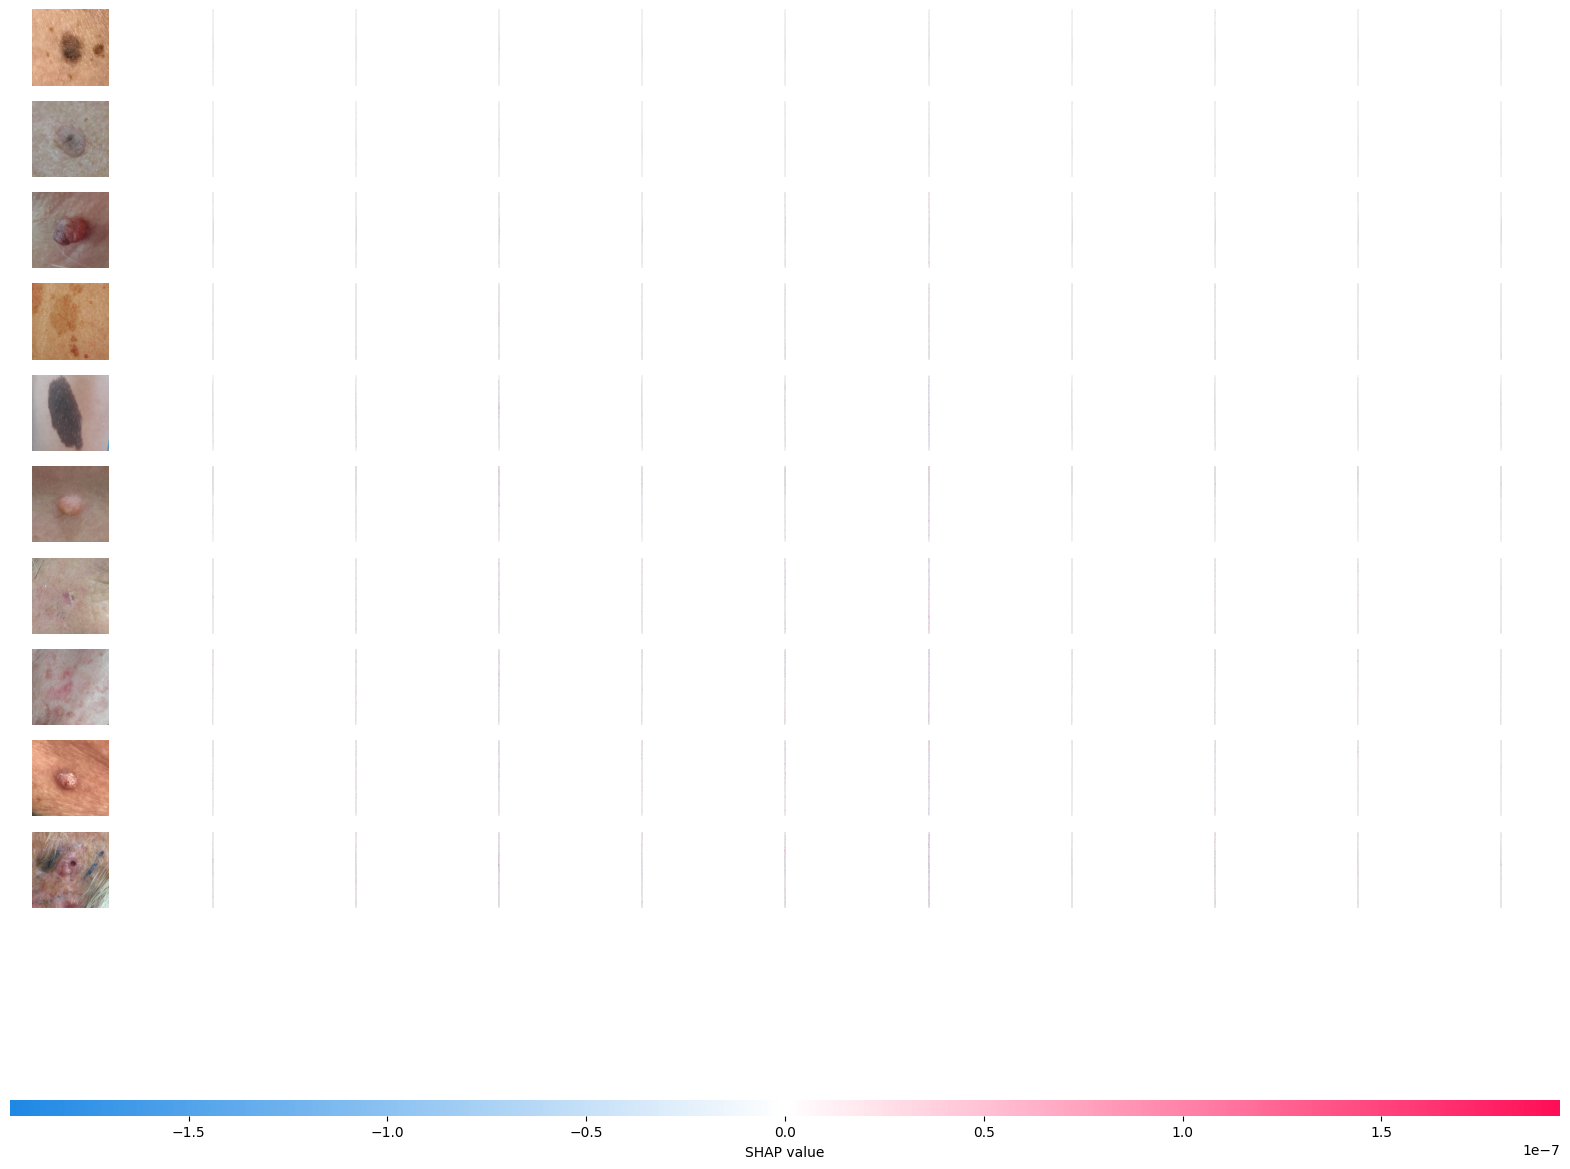

✅ Explanations saved to: /content/drive/MyDrive/AML2_Project_Results


In [10]:

# ======================================================
# 📘 PHASE 5: Explainable AI – LIME + SHAP Visualization
# ======================================================

import os
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import load_model

# --------------------------------------------
# 1️⃣ Mount Drive and Load Model + Data
# --------------------------------------------
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive"
model_path = os.path.join(base_path, "AML2_Project_Models/cnn_model.h5")
data_path  = os.path.join(base_path, "AML2_Project_Preprocessed")

model = load_model(model_path)
X_test = np.load(os.path.join(data_path, "X_test.npy"))
y_test = np.load(os.path.join(data_path, "y_test.npy"))

class_names = ['NEV', 'ACK', 'SEK', 'BCC', 'MEL', 'SCC']

# Ensure y_test is integer encoded
if len(y_test.shape) == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

print("✅ Model and data loaded successfully.")
print(f"Test shape: {X_test.shape}, Labels: {y_true.shape}")

# --------------------------------------------
# 2️⃣ Choose Samples to Explain
# --------------------------------------------
# Randomly pick 5 test images
sample_idxs = random.sample(range(len(X_test)), 5)
X_samples = X_test[sample_idxs]
y_samples = y_true[sample_idxs]

# Model predictions
pred_probs = model.predict(X_samples)
y_preds = np.argmax(pred_probs, axis=1)

# --------------------------------------------
# 3️⃣ Local Explanation with LIME
# --------------------------------------------
!pip install lime --quiet
from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()

for i, idx in enumerate(sample_idxs):
    explanation = explainer.explain_instance(
        X_test[idx].astype('double'),
        model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        label=y_preds[i],
        positive_only=False,
        hide_rest=False,
        num_features=5,
        min_weight=0.0
    )

    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(X_test[idx])
    plt.title(f"Original\nTrue: {class_names[y_true[idx]]}\nPred: {class_names[y_preds[i]]}")

    plt.subplot(1,2,2)
    plt.imshow(mark_boundaries(temp/255.0, mask))
    plt.title("LIME Explanation")
    plt.axis('off')
    plt.show()

# --------------------------------------------
# 4️⃣ Global Explanation with SHAP
# --------------------------------------------
!pip install shap --quiet
import shap

# Compute SHAP values for a subset of test images
subset_idx = np.random.choice(len(X_test), 50, replace=False)
X_subset = X_test[subset_idx]

# Select 20 background samples for reference
background = X_subset[:20]

# Use GradientExplainer for CNN models
explainer = shap.GradientExplainer(model, background)

# Calculate SHAP values for 10 test samples
shap_values = explainer.shap_values(X_subset[20:30])

# Normalise SHAP values for better visual contrast
shap_values = [sv / (np.max(np.abs(sv)) + 1e-8) for sv in shap_values]

# Plot global SHAP image summary
plt.title("SHAP Summary – Global Feature Influence (Normalised)")
shap.image_plot(shap_values, X_subset[20:30])

# --------------------------------------------
# 5️⃣ Save Results
# --------------------------------------------
results_dir = os.path.join(base_path, "AML2_Project_Results")
os.makedirs(results_dir, exist_ok=True)
np.save(os.path.join(results_dir, "shap_values.npy"), shap_values)

print(f"✅ Explanations saved to: {results_dir}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


✅ Model Evaluation Summary

{
    "Class 0": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 73.0
    },
    "Class 1": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 85.0
    },
    "Class 2": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 5.0
    },
    "Class 3": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 24.0
    },
    "Class 4": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 20.0
    },
    "Class 5": {
        "precision": 0.1,
        "recall": 1.0,
        "f1-score": 0.18181818181818182,
        "support": 23.0
    },
    "accuracy": 0.1,
    "macro avg": {
        "precision": 0.016666666666666666,
        "recall": 0.16666666666666666,
        "f1-score": 0.030303030303030304,
        "support": 230.0
    },
    "weighted avg": {
     

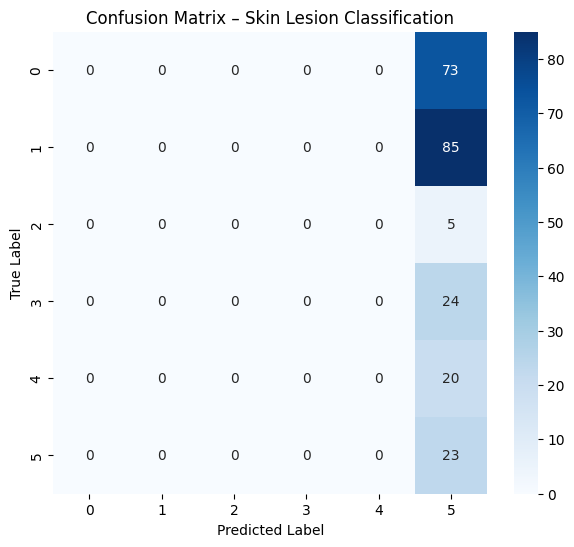

In [11]:
import json
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --------------------------------------------
# Phase 6 – Model Summary & Report
# --------------------------------------------

# Evaluate model again to refresh metrics
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# If y_test is already integer labels, skip argmax
try:
    y_true = np.argmax(y_test, axis=1)
except:
    y_true = y_test

# Classification report and confusion matrix
report = classification_report(y_true, y_pred, target_names=[f'Class {i}' for i in range(len(np.unique(y_true)))], output_dict=True)
conf_mat = confusion_matrix(y_true, y_pred)

# Print and save results
print("✅ Model Evaluation Summary\n")
print(json.dumps(report, indent=4))
print("\nConfusion Matrix:\n", conf_mat)

# Plot confusion matrix
plt.figure(figsize=(7,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix – Skin Lesion Classification")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


In [12]:
# Phase 7 – Build Gradio App for Prediction + Explanation

In [13]:
!pip install gradio


In [14]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.vgg16 import preprocess_input


In [15]:
# Step 2 — Load Model and Define Preprocessing

In [16]:
# Load your trained model
model_path = "/content/drive/MyDrive/AML2_Project_Models/cnn_model.h5"
model = load_model(model_path)
print("✅ Model loaded successfully!")

# Define class names (update based on your dataset)
class_names = [
    'Actinic Keratoses',        # Class 0
    'Basal Cell Carcinoma',     # Class 1
    'Benign Keratosis',         # Class 2
    'Dermatofibroma',           # Class 3
    'Melanoma',                 # Class 4
    'Nevus'                     # Class 5
]

# Function to preprocess input image
def preprocess_image(img):
    img = img.resize((224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array


✅ Model loaded successfully!


In [17]:
# Step 3 — Define Prediction and Explanation Function

In [18]:
def predict_and_explain(img):
    # Preprocess
    img_array = preprocess_image(img)

    # Prediction
    preds = model.predict(img_array)
    pred_class = np.argmax(preds, axis=1)[0]
    confidence = float(np.max(preds))

    # LIME Explanation
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        img_array[0].astype('double'),
        model.predict,
        top_labels=1,
        hide_color=0,
        num_samples=1000
    )

    temp, mask = explanation.get_image_and_mask(
        label=pred_class,
        positive_only=True,
        hide_rest=False,
        num_features=5,
        min_weight=0.05
    )

    lime_img = mark_boundaries(temp / 255.0, mask)

    # Create readable output
    result = {class_names[i]: float(preds[0][i]) for i in range(len(class_names))}
    result_text = f"Predicted: {class_names[pred_class]} (Confidence: {confidence:.2f})"

    return lime_img, result_text, result


In [19]:
# Step 4 — Build the Gradio Interface

In [20]:
# Create Gradio interface
interface = gr.Interface(
    fn=predict_and_explain,
    inputs=gr.Image(type="pil", label="Upload a Skin Lesion Image"),
    outputs=[
        gr.Image(type="numpy", label="LIME Explanation"),
        gr.Textbox(label="Prediction Summary"),
        gr.Label(label="Class Probabilities")
    ],
    title="🩺 Skin Lesion Classification with Explainable AI",
    description="Upload an image to view the model prediction and LIME-based explanation."
)

# Launch app
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://73102a65eb5f4b111d.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
